# Classification of Malicious URL using Deep Learning with Keras


In [2]:
!pip install scikeras

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier, KerasRegressor

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# mount the colab
from google.colab import drive
drive.mount('/content/drive')

# For saving and retrieving the trained model
WORKSPACE_PATH = "/content/drive/MyDrive/Colab Notebooks/models/"

Mounted at /content/drive


# Load the dataset



In [5]:
# Read the dataset
url = 'https://raw.githubusercontent.com/quickheaven/scs-3546-deep-learning/master/datasets/'

X_train = pd.read_csv(url + 'X_train.csv', index_col=0)
X_test =pd.read_csv(url + 'X_test.csv', index_col=0)

y_train =pd.read_csv(url + 'y_train.csv', index_col=0)
y_test = pd.read_csv(url + 'y_test.csv', index_col=0)

In [6]:
y_train_dummy = to_categorical(y_train)
y_test_dummy = to_categorical(y_test)


# Training and Tuning Model

The training and tuning of model is divided into three main experiments. Tuning of Deep Network, Tuning the Back Propagation and last is the Overfitting Management.

The first step before proceeding to other experiments is Tuning the Neural Network. These includes determining first the epoch and batch size to use, the number of hidden layers to add, the number of nodes in each layer, choosing the activation function and the weight initializer.

The second part is Tuning the Back Propagation. It involves whether to use Batch normalization or not, finding the right Optimizers and its Learning Rates.

Lastly is the Overfitting Management, I used Regularation and Dropout as part of the experiment.

In [31]:
def get_base_model_config():
  """
  This function returns the based model configuration for the experiments.

  Parameters
  ----------
  None

  Returns
  ----------
  dict - The dictionary containing the based model configuration.
  """

  early_stopping_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
  callbacks = [early_stopping_callback]

  model_config = {
      # ##################################
      "model_name": None,
      "input_dim": 51, # TODO
      "custom_layers": list(),
      "callbacks": callbacks,
      "validation_split": 0.20,
      "loss": "categorical_crossentropy",
      "output_nodes": 5, # TODO
      "output_activation": "softmax",
      "metrics": ['accuracy'],
      # ##################################
      "batch_size": 32,
      "epochs": 200,
      "hidden_activation": "relu",
      "weights_initializer": "random_normal",
      # ##################################
      "normalization": None,
      "optimizer": "adam",
      "learning_rate": 0.001,
      "regularizer": None,
      "dropout_rate": None, #0.0,
      # ##################################
      "is_save_model": False,
      "workspace_path": WORKSPACE_PATH,
      "verbose": 1
  }
  return model_config


In [25]:
def get_optimizer(optimizer_name, learning_rate):
  """
  (str. float) -> keras.optimizers

  This method returns the optimizer that will be use in the experiment.

  Parameters
  ----------
  optimizer_name - The name of the optimizer to use in the experiment. values are adagrad, rmsprop, adam and None.
  learning_rate - The rate of learning to use in the optimizer.

  Returns
  ----------
  keras.optimizer - The keras optimizer object.
  """
  optimizer=None
  if optimizer_name == 'adagrad':
      optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
  elif 'rmsprop':
      optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif'adam' :
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  else :
      optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

  return optimizer

In [32]:
def create_and_run_model(model_config, X, y):

  # Build the new model
  model = Sequential(layers=model_config['custom_layers'], name=model_config['model_name'])
  model.summary()

  optimizer = get_optimizer(model_config["optimizer"], model_config["learning_rate"])

  # Compile the model
  model.compile(optimizer=optimizer,
                loss=model_config['loss'],
                metrics=model_config['metrics'])

  # Fit the model
  history = model.fit(X, y,
                      batch_size=model_config['batch_size'],
                      callbacks=model_config['callbacks'],
                      epochs=model_config['epochs'],
                      validation_split=model_config['validation_split'],
                      verbose=model_config["verbose"])

  if True == model_config['is_save_model']:
    model_file = str(model_config['workspace_path']) + str(model_config['model_name']) + '.h5'
    model.save(model_file)

  return history

In [27]:
def plot_accuracy_measures(accuracy_measures, title):

    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))
    for experiment in accuracy_measures.keys():
        plt.plot(accuracy_measures[experiment],
                 label=experiment,
                    linewidth=3)

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [28]:
def plot_learning_curves(history, title):
  # plot curves for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Learning Curves ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.plot(figsize=(8, 5))
  plt.grid(True)
  plt.show()

In [29]:
model_config = get_base_model_config()

## Tuning Deep Neural Network

### Epoch and Batch size tuning
Figure out the right number of batches and epochs first, and then use that for further experimentation.

**Batch Size:** Experiment for the right size, batch size of 32 found most optimal for most use cases.

**Epoch:** Choose the earliest value when accuracy stabilizers.


Model: "Epoch_and_batch_size_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 16)                832       
                                                                 
 dense_57 (Dense)            (None, 5)                 85        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 1.3098 - accuracy: 0.5562 - val_loss: 1.1090 - val_accuracy: 0.6270
Epoch 2/200
636/636 [==============================] - 2s 4ms/step - loss: 1.0286 - accuracy: 0.6610 - val_loss: 0.9470 - val_accuracy: 0.6840
Epoch 3/200
636/636 [==============================] - 2s 3ms/step - loss: 0.9081 - accuracy: 0.6866 - val_loss: 0.8614 - v

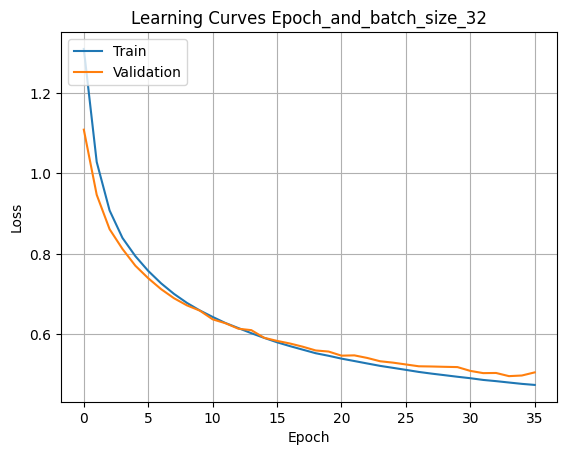

Model: "Epoch_and_batch_size_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 16)                832       
                                                                 
 dense_59 (Dense)            (None, 5)                 85        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
318/318 [==============================] - 2s 4ms/step - loss: 1.4138 - accuracy: 0.4969 - val_loss: 1.2261 - val_accuracy: 0.6140
Epoch 2/200
318/318 [==============================] - 1s 4ms/step - loss: 1.1357 - accuracy: 0.6307 - val_loss: 1.0335 - val_accuracy: 0.6631
Epoch 3/200
318/318 [==============================] - 1s 3ms/step - loss: 0.9851 - accuracy: 0.6663 - val_loss: 0.9250 - v

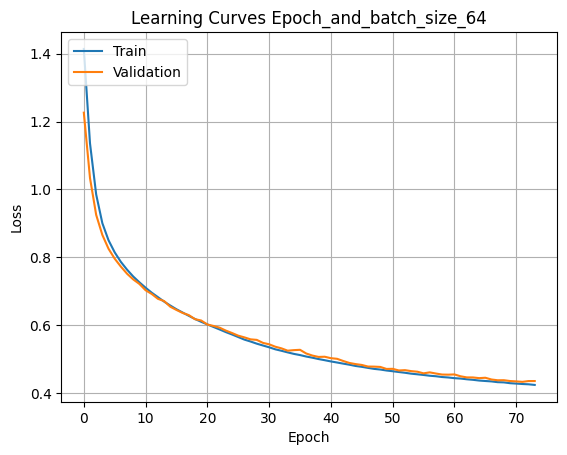

Model: "Epoch_and_batch_size_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 16)                832       
                                                                 
 dense_61 (Dense)            (None, 5)                 85        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
159/159 [==============================] - 2s 7ms/step - loss: 1.4871 - accuracy: 0.4364 - val_loss: 1.3484 - val_accuracy: 0.5621
Epoch 2/200
159/159 [==============================] - 1s 4ms/step - loss: 1.2541 - accuracy: 0.5994 - val_loss: 1.1578 - val_accuracy: 0.6411
Epoch 3/200
159/159 [==============================] - 1s 4ms/step - loss: 1.1090 - accuracy: 0.6461 - val_loss: 1.0438 - 

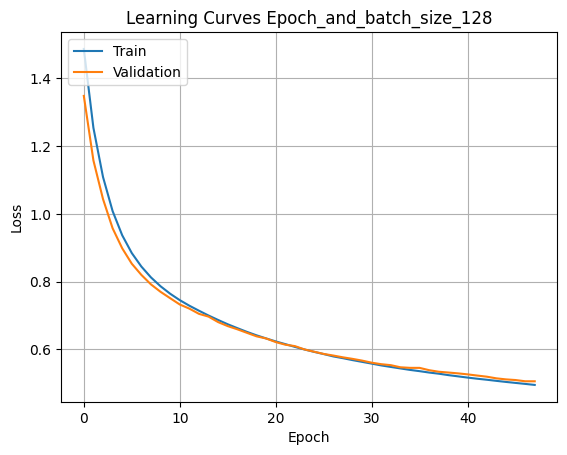

In [33]:
accuracy_measures = {}
model_config = get_base_model_config()

batch_sizes = [32, 64, 128]

for size in batch_sizes:

  model_config['batch_size'] = size

  custom_layers = [
      layers.Dense(16, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];
  model_name = 'Epoch_and_batch_size_' + str(size)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [34]:
accuracy_measures_batch_epoch = accuracy_measures.copy()

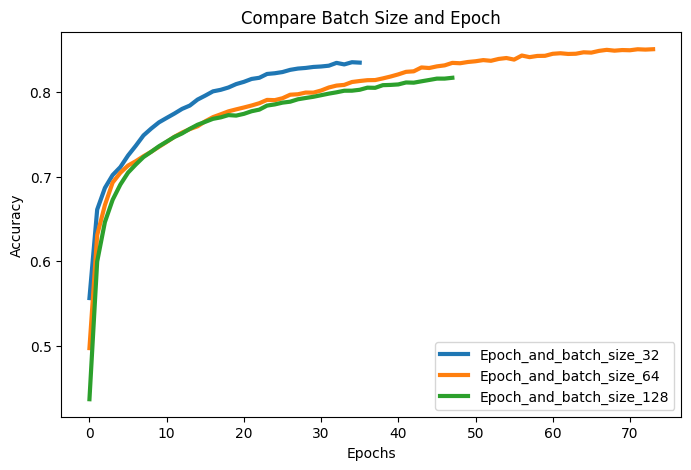

In [35]:
plot_accuracy_measures(accuracy_measures, "Compare Batch Size and Epoch")

For this use case, it seems there is no benefits on increasing the batch size further. Moving forward I am just going to use the batch size of 32.\
Meanwhile, the earliest epoch where stabilization happens was 50.

In [36]:
model_config['batch_size'] = 32
model_config['epochs'] = 40

### Hidden layers tuning

One of the key model architecture hyperparameters is the number of hidden layers. As the number of layers increases, it increases the possibility of learning complex relationships between features and target variables, but it will also increase the cost and time needed for both training and inference. It is also has the risk of overfitting the training set.

A **value of two** has been sufficient for simple problems. It is recommended to increase the number of layers only based on experimentation if the set accuracy levels are not achieved. Otherwise, additional layers will take resources and time without providing any additional value.

Model: "Layers_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 16)                832       
                                                                 
 dense_63 (Dense)            (None, 5)                 85        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 5ms/step - loss: 1.2933 - accuracy: 0.5481 - val_loss: 1.0734 - val_accuracy: 0.6333
Epoch 2/40
636/636 [==============================] - 3s 4ms/step - loss: 0.9924 - accuracy: 0.6641 - val_loss: 0.9113 - val_accuracy: 0.6881
Epoch 3/40
636/636 [==============================] - 2s 3ms/step - loss: 0.8842 - accuracy: 0.6895 - val_loss: 0.8405 - val_accuracy: 0.691

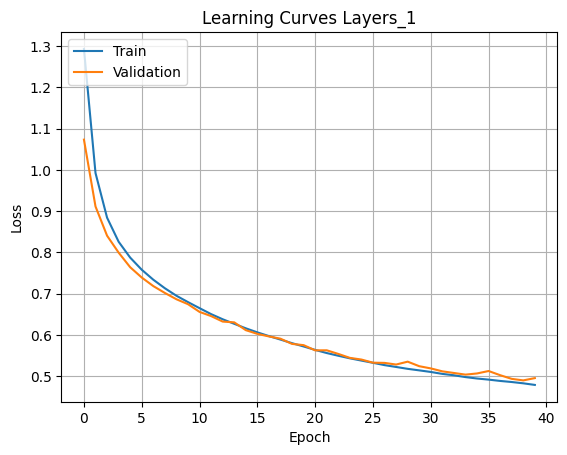

Model: "Layers_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 16)                832       
                                                                 
 dense_65 (Dense)            (None, 16)                272       
                                                                 
 dense_66 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1189 (4.64 KB)
Trainable params: 1189 (4.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.2810 - accuracy: 0.5268 - val_loss: 1.0289 - val_accuracy: 0.6162
Epoch 2/40
636/636 [==============================] - 2s 4ms/step - loss: 0.9421 - accuracy: 0.6601 - val_loss: 0.8689 - val_accuracy: 0.6906
Epoch 

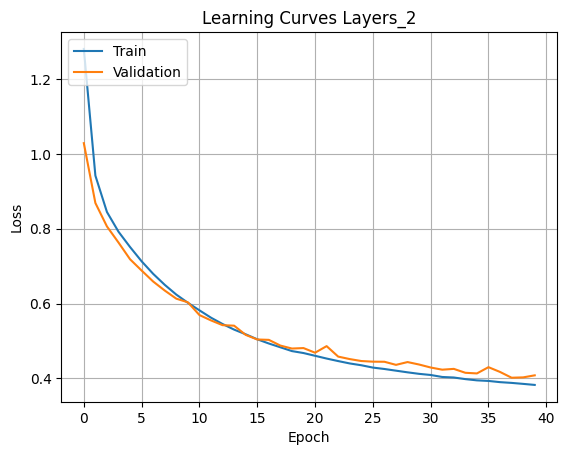

Model: "Layers_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 16)                832       
                                                                 
 dense_68 (Dense)            (None, 16)                272       
                                                                 
 dense_69 (Dense)            (None, 16)                272       
                                                                 
 dense_70 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1461 (5.71 KB)
Trainable params: 1461 (5.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 5s 6ms/step - loss: 1.3184 - accuracy: 0.4935 - val_loss: 1.0911 - val_accuracy: 0.5957
Epoch 2/40
636/6

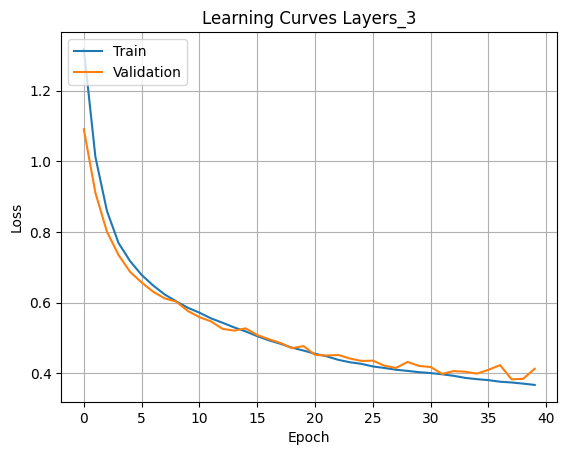

Model: "Layers_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 16)                832       
                                                                 
 dense_72 (Dense)            (None, 16)                272       
                                                                 
 dense_73 (Dense)            (None, 16)                272       
                                                                 
 dense_74 (Dense)            (None, 16)                272       
                                                                 
 dense_75 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1733 (6.77 KB)
Trainable params: 1733 (6.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [======

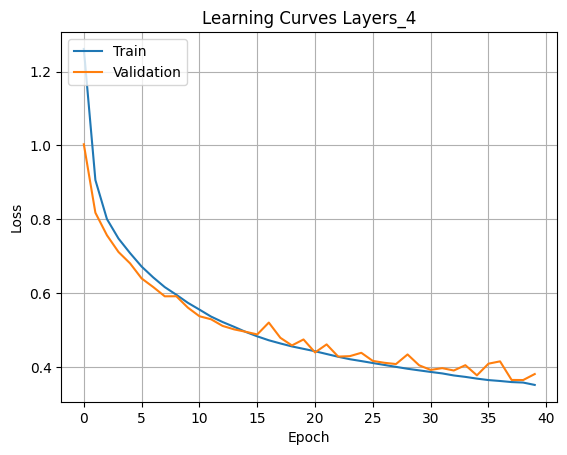

Model: "Layers_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 16)                832       
                                                                 
 dense_77 (Dense)            (None, 16)                272       
                                                                 
 dense_78 (Dense)            (None, 16)                272       
                                                                 
 dense_79 (Dense)            (None, 16)                272       
                                                                 
 dense_80 (Dense)            (None, 16)                272       
                                                                 
 dense_81 (Dense)            (None, 5)                 85        
                                                                 
Total params: 2005 (7.83 KB)
Trainable params: 2005 (7.83 

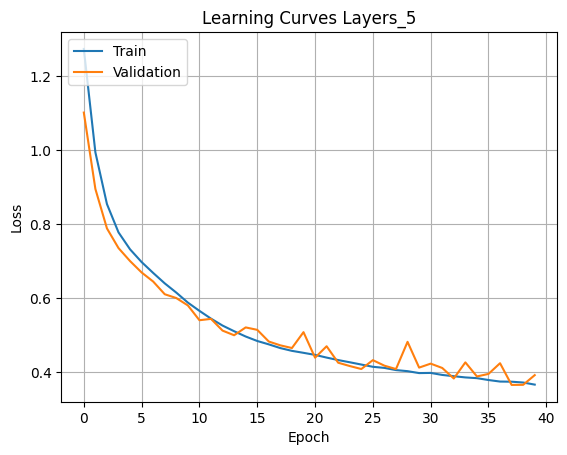

Model: "Layers_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 16)                832       
                                                                 
 dense_83 (Dense)            (None, 16)                272       
                                                                 
 dense_84 (Dense)            (None, 16)                272       
                                                                 
 dense_85 (Dense)            (None, 16)                272       
                                                                 
 dense_86 (Dense)            (None, 16)                272       
                                                                 
 dense_87 (Dense)            (None, 16)                272       
                                                                 
 dense_88 (Dense)            (None, 5)                 85 

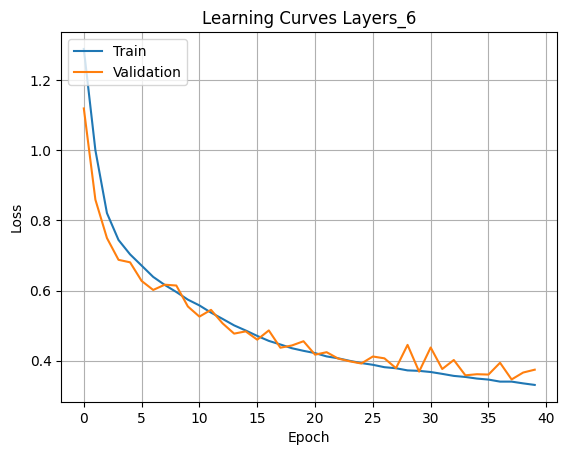

Model: "Layers_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 16)                832       
                                                                 
 dense_90 (Dense)            (None, 16)                272       
                                                                 
 dense_91 (Dense)            (None, 16)                272       
                                                                 
 dense_92 (Dense)            (None, 16)                272       
                                                                 
 dense_93 (Dense)            (None, 16)                272       
                                                                 
 dense_94 (Dense)            (None, 16)                272       
                                                                 
 dense_95 (Dense)            (None, 16)                272

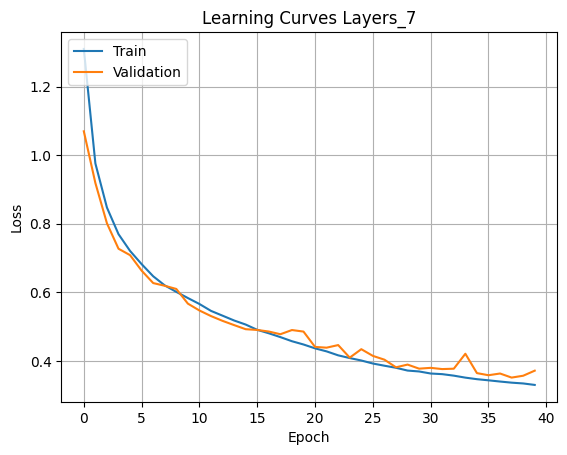

Model: "Layers_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_97 (Dense)            (None, 16)                832       
                                                                 
 dense_98 (Dense)            (None, 16)                272       
                                                                 
 dense_99 (Dense)            (None, 16)                272       
                                                                 
 dense_100 (Dense)           (None, 16)                272       
                                                                 
 dense_101 (Dense)           (None, 16)                272       
                                                                 
 dense_102 (Dense)           (None, 16)                272       
                                                                 
 dense_103 (Dense)           (None, 16)                272

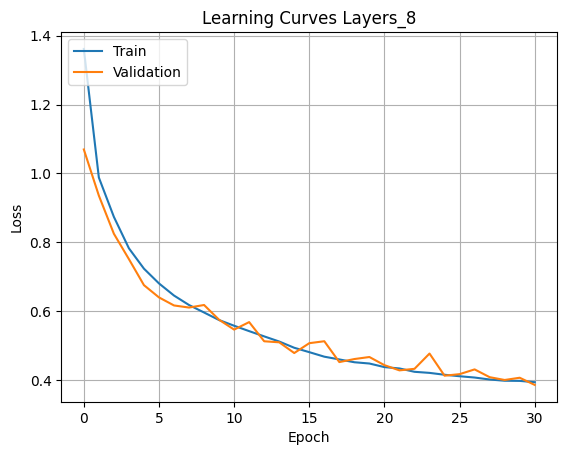

Model: "Layers_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_106 (Dense)           (None, 16)                832       
                                                                 
 dense_107 (Dense)           (None, 16)                272       
                                                                 
 dense_108 (Dense)           (None, 16)                272       
                                                                 
 dense_109 (Dense)           (None, 16)                272       
                                                                 
 dense_110 (Dense)           (None, 16)                272       
                                                                 
 dense_111 (Dense)           (None, 16)                272       
                                                                 
 dense_112 (Dense)           (None, 16)                272

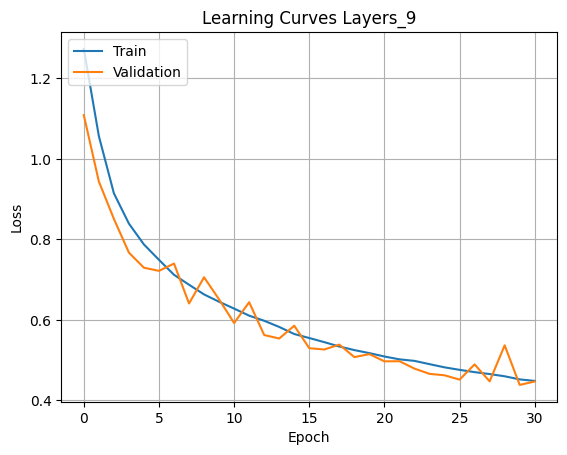

Model: "Layers_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 16)                832       
                                                                 
 dense_117 (Dense)           (None, 16)                272       
                                                                 
 dense_118 (Dense)           (None, 16)                272       
                                                                 
 dense_119 (Dense)           (None, 16)                272       
                                                                 
 dense_120 (Dense)           (None, 16)                272       
                                                                 
 dense_121 (Dense)           (None, 16)                272       
                                                                 
 dense_122 (Dense)           (None, 16)                27

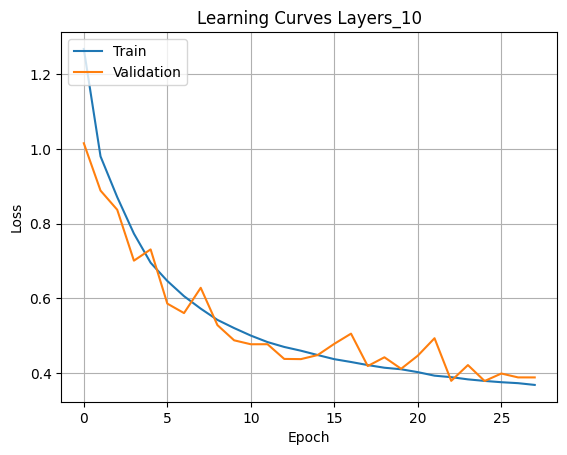

In [37]:
model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 40

accuracy_measures = {}

# reused the previous model config from previous experiment.
# but on this case only increase the number of layers

# I will start small by checking if one or two nodes is enough to get a good result.
layer_list = []
for hidden_layer_count in range(1,11):
  custom_layers = []

  # Simply use 16 nodes per layer for now.

  # Input
  if hidden_layer_count == 1:
    custom_layers.append(layers.Dense(16, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']))
  else:
  # Additional Layers
    custom_layers.append(layers.Dense(16, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']))
    for i in range(1, hidden_layer_count):
      custom_layers.append(layers.Dense(16, activation=model_config['hidden_activation']))

  # Output layers
  custom_layers.append(layers.Dense(model_config['output_nodes'], activation=model_config['output_activation']))

  model_name = 'Layers_' + str(hidden_layer_count)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [38]:
accuracy_measures_hidden_layers = accuracy_measures.copy()

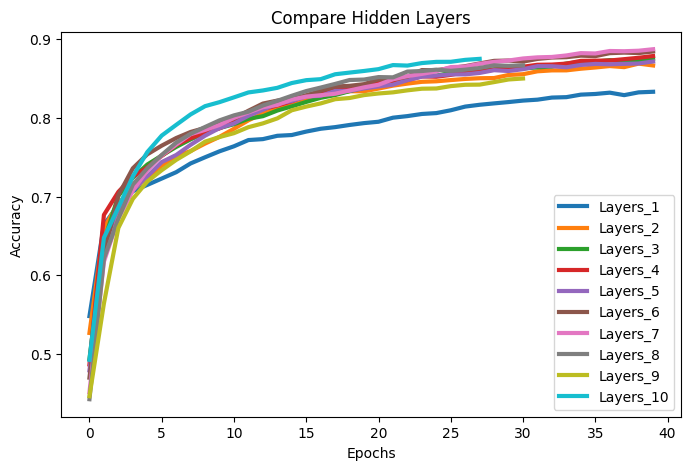

In [39]:
plot_accuracy_measures(accuracy_measures, "Compare Hidden Layers")

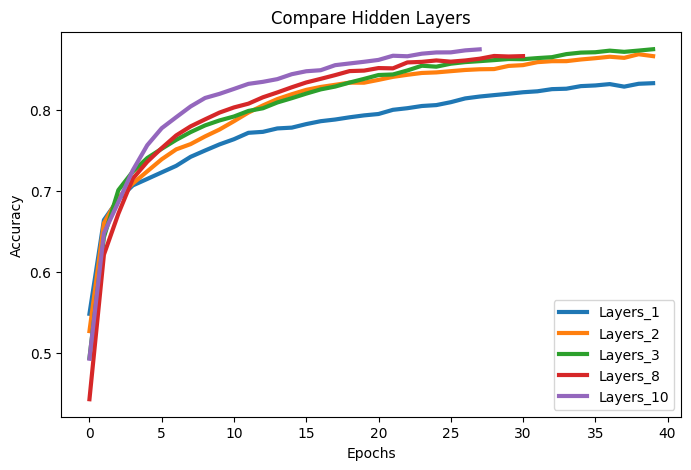

In [45]:
accuracy_measures_tmp = {}
accuracy_measures_tmp['Layers_1'] = accuracy_measures['Layers_1']
accuracy_measures_tmp['Layers_2'] = accuracy_measures['Layers_2']
accuracy_measures_tmp['Layers_3'] = accuracy_measures['Layers_3']
accuracy_measures_tmp['Layers_8'] = accuracy_measures['Layers_8']
accuracy_measures_tmp['Layers_10'] = accuracy_measures['Layers_10']

plot_accuracy_measures(accuracy_measures_tmp, "Compare Hidden Layers")

The Layers_8 and Layers_10 completed faster but looking to individual learning curve, they are not stable unlike the model with the first three count layers. On those first three models, the model Layers_3 offers a higher accuracy and stability. The succeeding models with higher number of layers offers a better accuracy but those are starting to show signs of overfitting.

Hence, I will choose the model Layers_3. It is also a good idea to start with smaller number of layers.

### Determining nodes in a layers
More nodes means more possibility for the model to learn complex relationships. However similar to number of layers, it will results to more training and resources.

On my experiment I started with a low number as recommended with 32 nodes.


In [19]:
X_train.shape

(25437, 51)

Model: "Nodes-16-16-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_127 (Dense)           (None, 16)                832       
                                                                 
 dense_128 (Dense)           (None, 16)                272       
                                                                 
 dense_129 (Dense)           (None, 16)                272       
                                                                 
 dense_130 (Dense)           (None, 5)                 85        
                                                                 
Total params: 1461 (5.71 KB)
Trainable params: 1461 (5.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 4ms/step - loss: 1.2040 - accuracy: 0.5479 - val_loss: 0.9381 - val_accuracy: 0.6621
Epoch 2/40

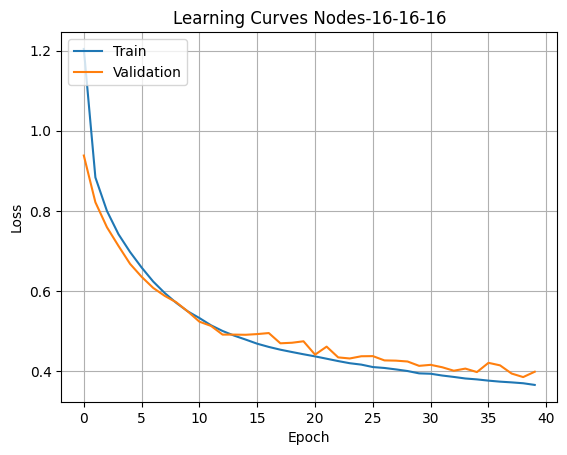

Model: "Nodes-16-24-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 16)                832       
                                                                 
 dense_132 (Dense)           (None, 24)                408       
                                                                 
 dense_133 (Dense)           (None, 16)                400       
                                                                 
 dense_134 (Dense)           (None, 5)                 85        
                                                                 
Total params: 1725 (6.74 KB)
Trainable params: 1725 (6.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.2385 - accuracy: 0.5185 - val_loss: 0.9771 - val_accuracy: 0.6185
Epoch 2/40

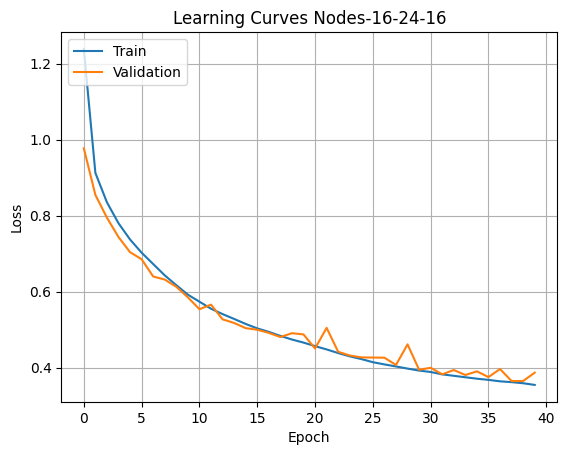

Model: "Nodes-24-16-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 24)                1248      
                                                                 
 dense_136 (Dense)           (None, 16)                400       
                                                                 
 dense_137 (Dense)           (None, 16)                272       
                                                                 
 dense_138 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2005 (7.83 KB)
Trainable params: 2005 (7.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.1876 - accuracy: 0.5606 - val_loss: 0.9451 - val_accuracy: 0.6545
Epoch 2/40

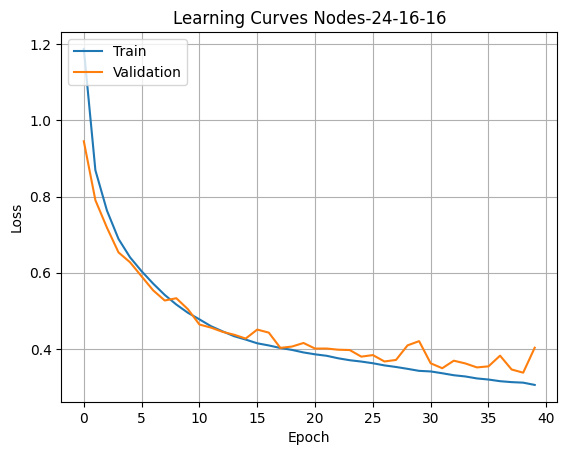

Model: "Nodes-24-24-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_139 (Dense)           (None, 24)                1248      
                                                                 
 dense_140 (Dense)           (None, 24)                600       
                                                                 
 dense_141 (Dense)           (None, 16)                400       
                                                                 
 dense_142 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2333 (9.11 KB)
Trainable params: 2333 (9.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 4ms/step - loss: 1.1893 - accuracy: 0.5647 - val_loss: 0.9274 - val_accuracy: 0.6859
Epoch 2/40

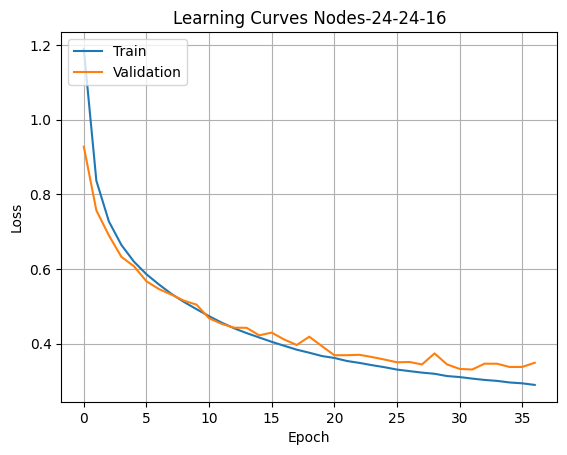

Model: "Nodes-32-16-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_143 (Dense)           (None, 32)                1664      
                                                                 
 dense_144 (Dense)           (None, 16)                528       
                                                                 
 dense_145 (Dense)           (None, 16)                272       
                                                                 
 dense_146 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.1802 - accuracy: 0.5775 - val_loss: 0.9196 - val_accuracy: 0.7003
Epoch 2/40

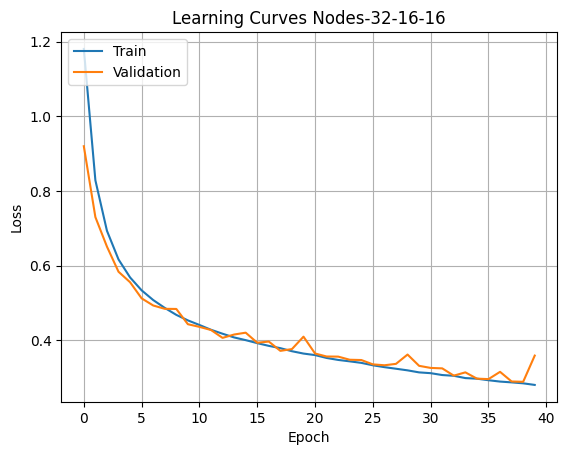

Model: "Nodes-32-24-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 32)                1664      
                                                                 
 dense_148 (Dense)           (None, 24)                792       
                                                                 
 dense_149 (Dense)           (None, 16)                400       
                                                                 
 dense_150 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2941 (11.49 KB)
Trainable params: 2941 (11.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.1177 - accuracy: 0.6037 - val_loss: 0.8663 - val_accuracy: 0.6814
Epoch 2/

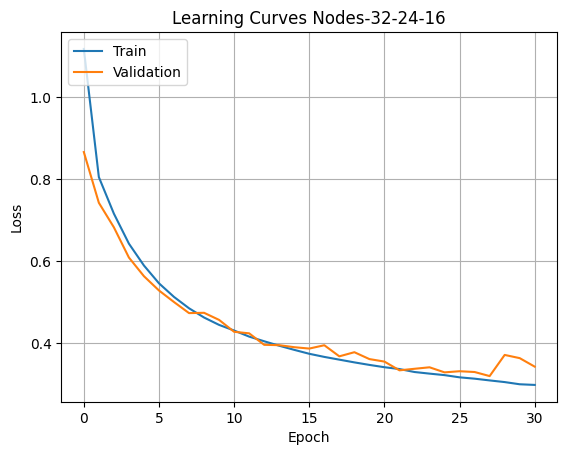

In [46]:
# reset the accuracy measures
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 40

# Exhaustive approach. Try all combinations of layers and the number of nodes;
node_list_layer_1 = [16, 24, 32]
node_list_layer_2 = [16, 24]
node_list_layer_3 = [16]

for nbr_of_nodes_layer_1 in node_list_layer_1:
  for nbr_of_nodes_layer_2 in node_list_layer_2:
    for nbr_of_nodes_layer_3 in node_list_layer_3:
        custom_layers = [
          layers.Dense(nbr_of_nodes_layer_1, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
          layers.Dense(nbr_of_nodes_layer_2, activation=model_config['hidden_activation']),
          layers.Dense(nbr_of_nodes_layer_3, activation=model_config['hidden_activation']),
          layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
        ];
        model_name = 'Nodes-' + str(nbr_of_nodes_layer_1) + '-' + str(nbr_of_nodes_layer_2) + '-' + str(nbr_of_nodes_layer_3)
        model_config['model_name'] = model_name
        model_config['custom_layers'].clear()
        model_config['custom_layers'].extend(custom_layers)

        history = create_and_run_model(model_config, X_train, y_train_dummy)
        plot_learning_curves(history, model_name)
        accuracy_measures[model_name] = history.history['accuracy']

In [47]:
accuracy_measures_nodes = accuracy_measures.copy()

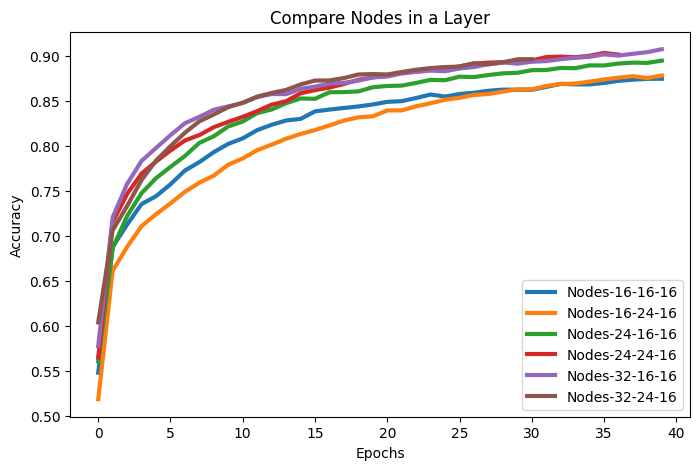

In [51]:
plot_accuracy_measures(accuracy_measures, "Compare Nodes in a Layer")

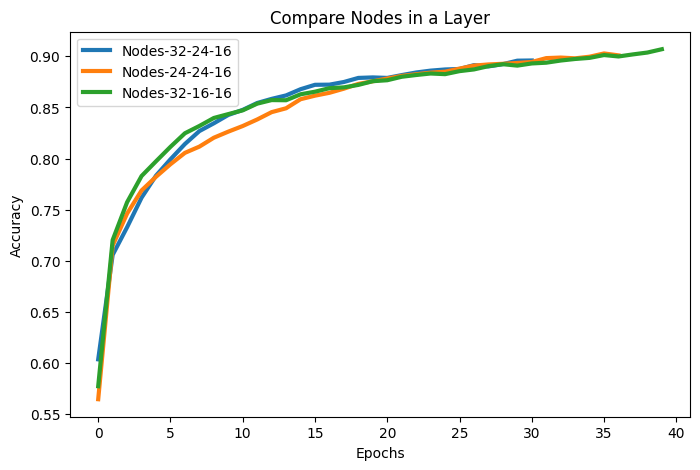

In [53]:
accuracy_measures_tmp = {}
accuracy_measures_tmp['Nodes-32-24-16'] = accuracy_measures['Nodes-32-24-16']
accuracy_measures_tmp['Nodes-32-16-16'] = accuracy_measures['Nodes-32-16-16']
accuracy_measures_tmp['Nodes-24-24-16'] = accuracy_measures['Nodes-24-24-16']

plot_accuracy_measures(accuracy_measures_tmp, "Compare Nodes in a Layer")

The models above almost have similar accuracy but model Nodes-32-16-16 have slightly higher accuracy and less signs of overfitting.

### Choosing Activation Function

There are number of algorithms available for activation functions. In general, rectified linear unit works best for regular  artificial neural network (ANN) and convolutional network (CNN). Sigmoid works best for RNNs.


Model: "Model-relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_151 (Dense)           (None, 32)                1664      
                                                                 
 dense_152 (Dense)           (None, 16)                528       
                                                                 
 dense_153 (Dense)           (None, 16)                272       
                                                                 
 dense_154 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.1634 - accuracy: 0.5742 - val_loss: 0.9274 - val_accuracy: 0.6547
Epoch 2/40
636

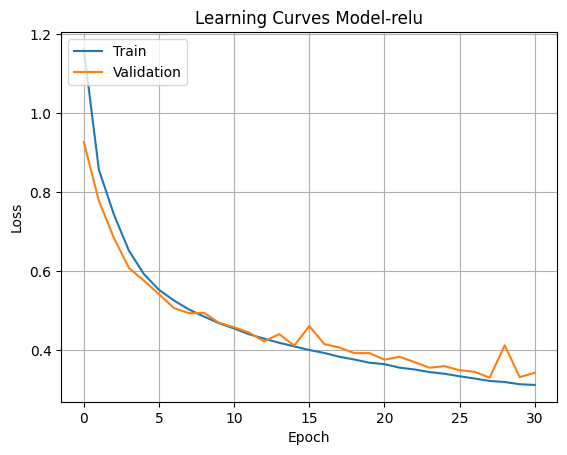

Model: "Model-sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_155 (Dense)           (None, 32)                1664      
                                                                 
 dense_156 (Dense)           (None, 16)                528       
                                                                 
 dense_157 (Dense)           (None, 16)                272       
                                                                 
 dense_158 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 5ms/step - loss: 1.6149 - accuracy: 0.2507 - val_loss: 1.5793 - val_accuracy: 0.4603
Epoch 2/40


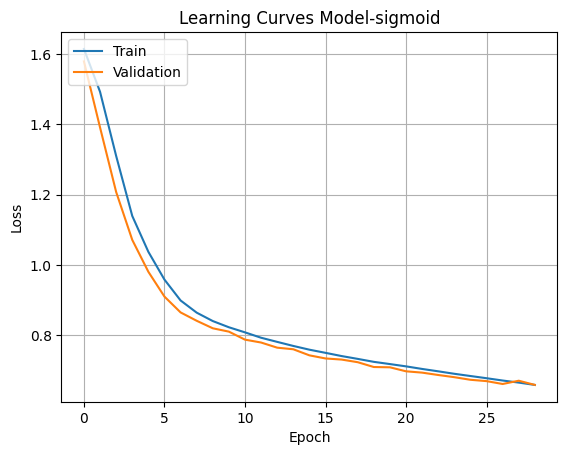

Model: "Model-tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_159 (Dense)           (None, 32)                1664      
                                                                 
 dense_160 (Dense)           (None, 16)                528       
                                                                 
 dense_161 (Dense)           (None, 16)                272       
                                                                 
 dense_162 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.0271 - accuracy: 0.6366 - val_loss: 0.8216 - val_accuracy: 0.7050
Epoch 2/40
636

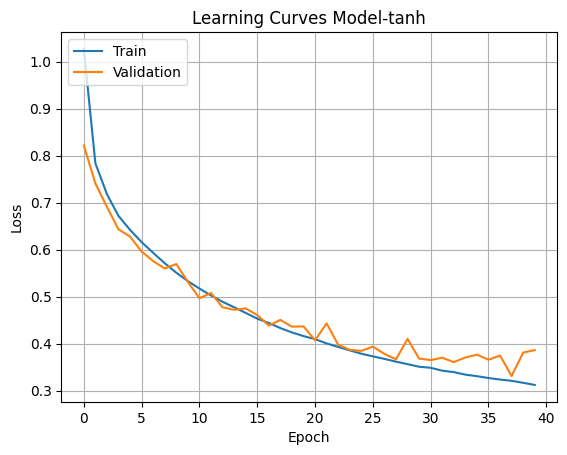

In [54]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 40
# Number of layers: 3
# Number of nodes per each layer: 32-16-16

activation_list = ['relu','sigmoid','tanh']

for activation in activation_list:

  model_config['hidden_activation'] = activation

  custom_layers = [
    layers.Dense(32, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(16, activation=model_config['hidden_activation']),
    layers.Dense(16, activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Model-' + activation
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [57]:
accuracy_activation = accuracy_measures.copy()

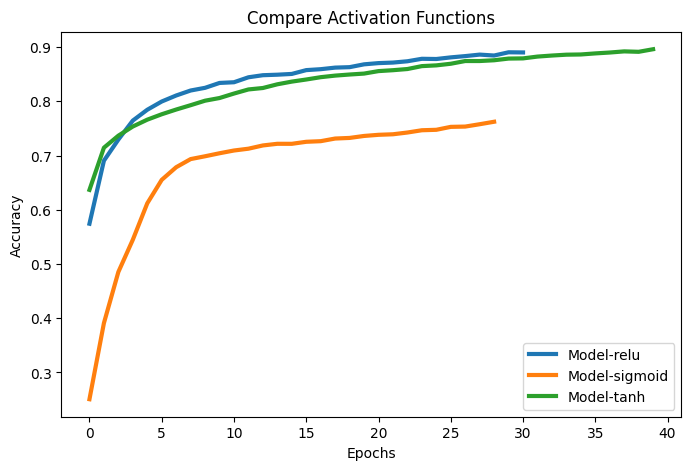

In [58]:
plot_accuracy_measures(accuracy_measures, "Compare Activation Functions")

The activation function relu have higher accuracy and completed faster.

In [59]:
model_config['hidden_activation'] = 'relu'

### Initialize Weights
The initial values of weights play a huge role in the speed of learning and finaly accuracy. Multiple initialization techniques exist.

Random normal works best for most cases but we will run an experiment if that is still the case on our dataset.

Model: "Model-random_normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_171 (Dense)           (None, 32)                1664      
                                                                 
 dense_172 (Dense)           (None, 16)                528       
                                                                 
 dense_173 (Dense)           (None, 16)                272       
                                                                 
 dense_174 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 5ms/step - loss: 1.4080 - accuracy: 0.3831 - val_loss: 1.1831 - val_accuracy: 0.5511
Epoch

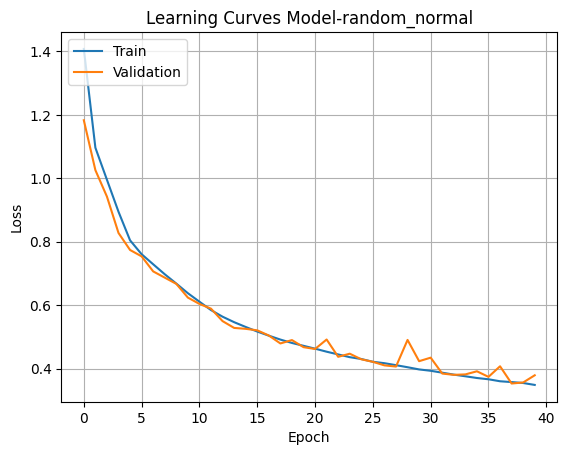

Model: "Model-random_uniform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_175 (Dense)           (None, 32)                1664      
                                                                 
 dense_176 (Dense)           (None, 16)                528       
                                                                 
 dense_177 (Dense)           (None, 16)                272       
                                                                 
 dense_178 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 5ms/step - loss: 1.3662 - accuracy: 0.3829 - val_loss: 1.2127 - val_accuracy: 0.4686
Epoc

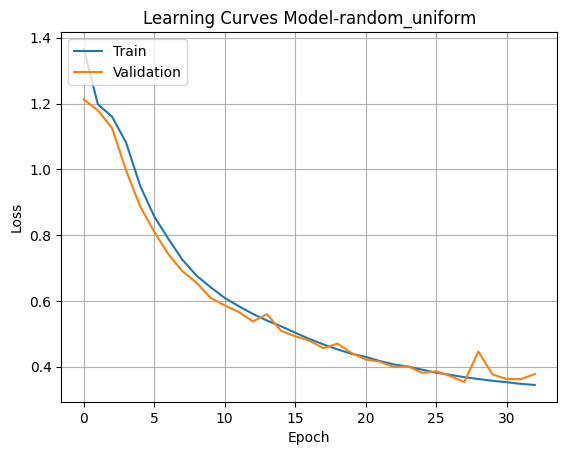

In [64]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 40
# Number of layers: 3
# Number of nodes per each layer: 32-16-16
model_config['hidden_activation'] = 'relu'

initializer_list = ['random_normal', "random_uniform"]

for initializer in initializer_list:

  model_config['weights_initializer'] = initializer

  custom_layers = [
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Model-' + initializer
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [65]:
accuracy_measures_weight_init = accuracy_measures.copy()

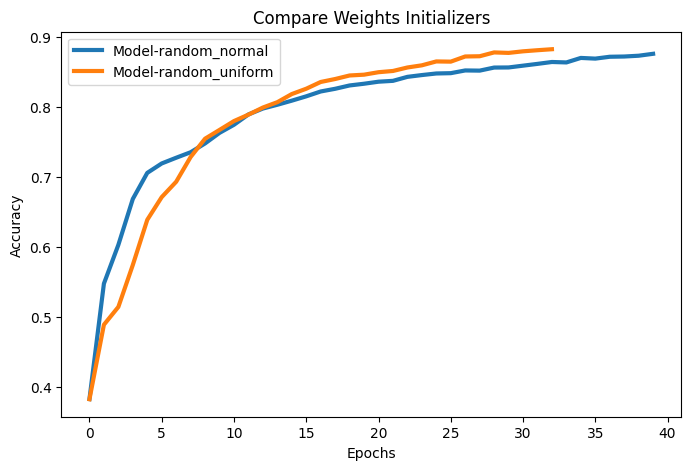

In [66]:
plot_accuracy_measures(accuracy_measures, "Compare Weights Initializers")

Both random_normal and random_uniform have similar high accuracy but random_normal completed faster. Hence, I will simply choose the random_normal as weight initializer.

In [63]:
model_config['weights_initializer'] = 'random_uniform'

## Tuning Back Propagation

### Batch Normalization

Batch normalization is an important technique to vanishing and exploiting gradients during gradient descent. Batch normalization help achieve higher accuracies with lower epochs, hence is also an optimization technique.

*This is no longer necessary because Scaler was already applied during data preparation.*

Model: "Normalization-batch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_179 (Dense)           (None, 32)                1664      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dense_180 (Dense)           (None, 16)                528       
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_181 (Dense)           (None, 16)                272       
                                                                 
 batch_normalization_2 (Bat  (None, 16)        

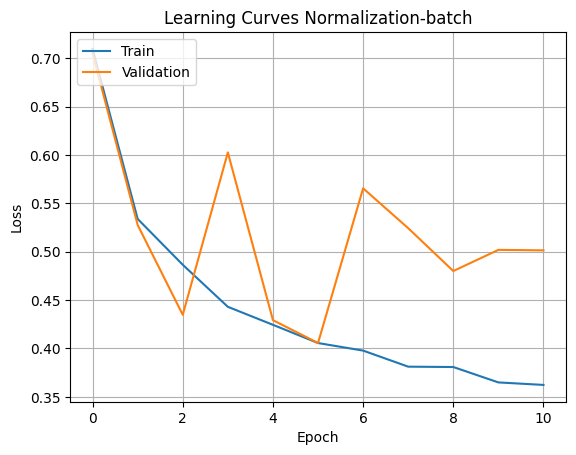

Model: "Normalization-none"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_183 (Dense)           (None, 32)                1664      
                                                                 
 dense_184 (Dense)           (None, 16)                528       
                                                                 
 dense_185 (Dense)           (None, 16)                272       
                                                                 
 dense_186 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.4224 - accuracy: 0.3628 - val_loss: 1.2899 - val_accuracy: 0.4292
Epoch 

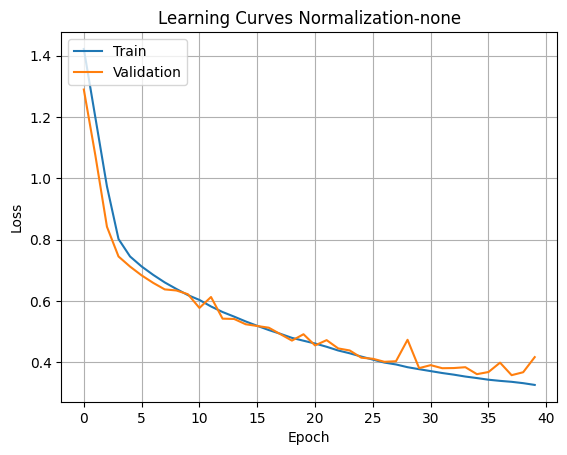

In [67]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 40
# Number of layers: 3
# Number of nodes per each layer: 32-16-16
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_uniform'

normalization_list = ['batch','none']
for normalization in normalization_list:

  custom_layers = []
  if normalization == 'none':
    custom_layers = [
      layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];
  else:
    custom_layers = [
      layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.BatchNormalization(),
      layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.BatchNormalization(),
      layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.BatchNormalization(),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];


  model_name = 'Normalization-' + normalization
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [68]:
accuracy_measures_normalization = accuracy_measures.copy()

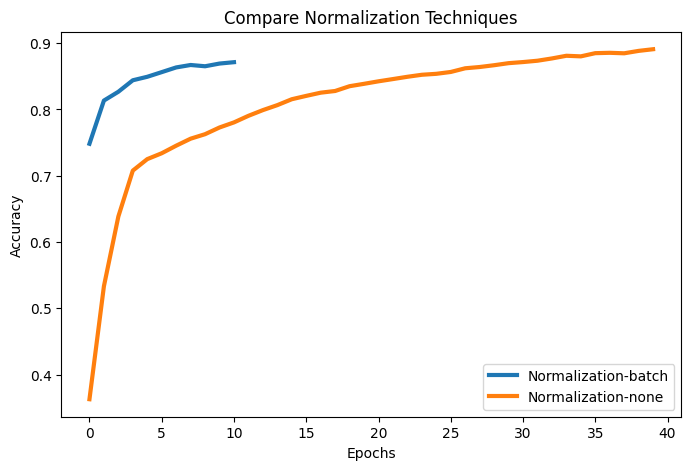

In [69]:
plot_accuracy_measures(accuracy_measures, "Compare Normalization Techniques")

The model with Batch normalization starts with higher accuracy and faster to stabilize and complete compared to the other model without normalization.

### Optimizers
Optimizer are key tools, that help gradient descent, achieve faster results. Optimizers are algorithms, that helps speed up the training process.

Model: "Optimizer-sgd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_187 (Dense)           (None, 32)                1664      
                                                                 
 dense_188 (Dense)           (None, 16)                528       
                                                                 
 dense_189 (Dense)           (None, 16)                272       
                                                                 
 dense_190 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 4ms/step - loss: 1.3845 - accuracy: 0.4212 - val_loss: 1.2171 - val_accuracy: 0.5318
Epoch 2/40


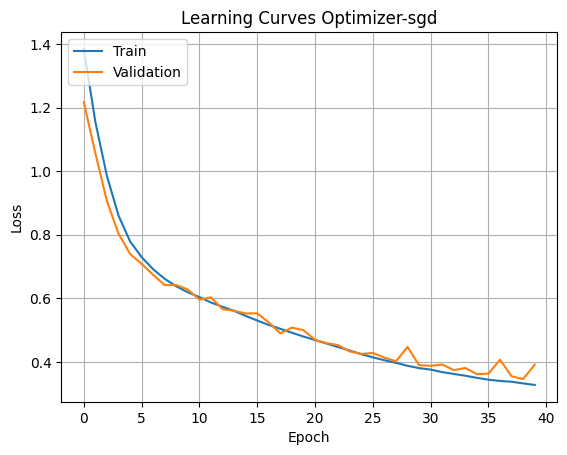

Model: "Optimizer-rmsprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_191 (Dense)           (None, 32)                1664      
                                                                 
 dense_192 (Dense)           (None, 16)                528       
                                                                 
 dense_193 (Dense)           (None, 16)                272       
                                                                 
 dense_194 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 5s 6ms/step - loss: 1.4098 - accuracy: 0.3649 - val_loss: 1.2549 - val_accuracy: 0.4595
Epoch 2

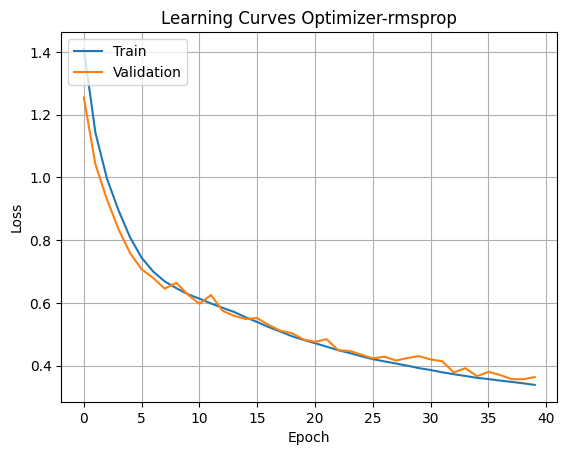

Model: "Optimizer-adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_195 (Dense)           (None, 32)                1664      
                                                                 
 dense_196 (Dense)           (None, 16)                528       
                                                                 
 dense_197 (Dense)           (None, 16)                272       
                                                                 
 dense_198 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 5s 6ms/step - loss: 1.3529 - accuracy: 0.4224 - val_loss: 1.1283 - val_accuracy: 0.5586
Epoch 2/40

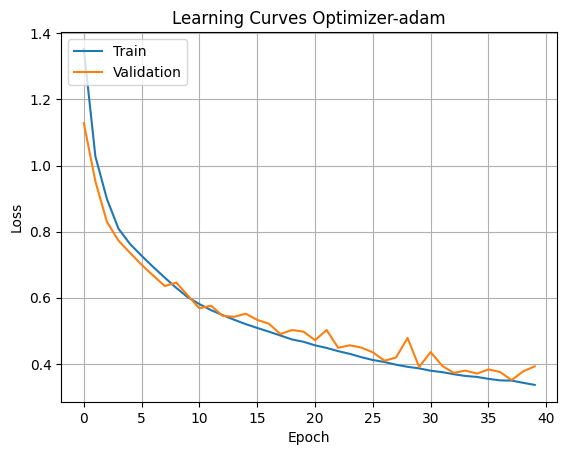

Model: "Optimizer-adagrad"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_199 (Dense)           (None, 32)                1664      
                                                                 
 dense_200 (Dense)           (None, 16)                528       
                                                                 
 dense_201 (Dense)           (None, 16)                272       
                                                                 
 dense_202 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 4ms/step - loss: 1.6089 - accuracy: 0.2105 - val_loss: 1.6084 - val_accuracy: 0.2134
Epoch 2

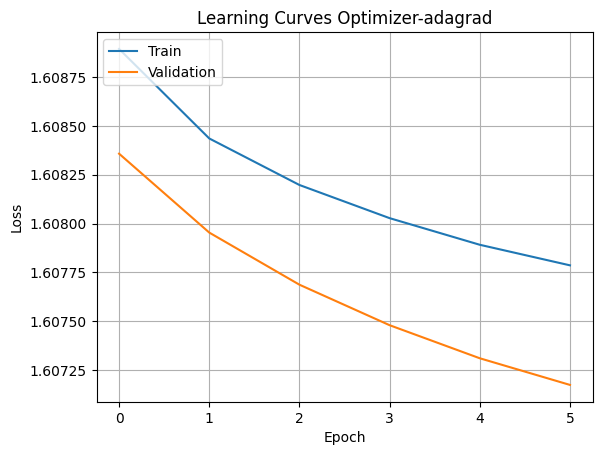

In [70]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 40
# Number of layers: 3
# Number of nodes per each layer: 32-16-16
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_uniform'
# Batch Normalization: not added

optimizer_list = ['sgd','rmsprop','adam','adagrad']

for optimizer in optimizer_list:

  model_config['optimizer'] = optimizer

  custom_layers = [
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Optimizer-' + optimizer
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [71]:
accuracy_measures_optimizer = accuracy_measures.copy()

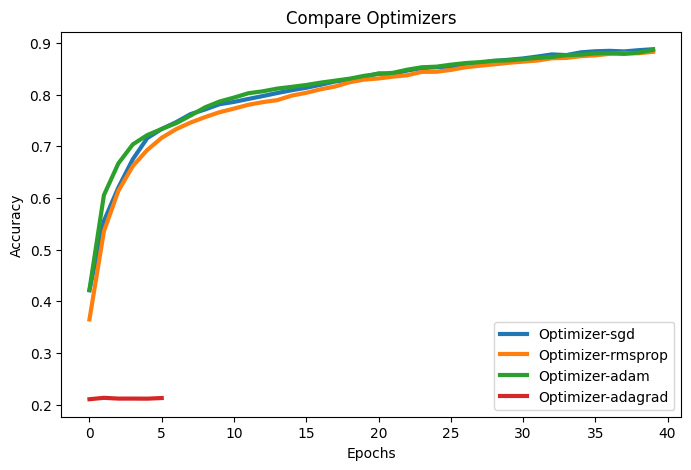

In [72]:
plot_accuracy_measures(accuracy_measures, "Compare Optimizers")

The of optimizer experiment is close but rmsprop is more stable and less signs of overfitting the model.

In [ ]:
model_config['optimizer'] = 'rmsprop'

### Learning Rates

Learning rate is the rate at  which the weights will change in response to the estimated error. It is the speed at which the model is expected to learn from the training data and adjust its weights. Learning rates work in conjunction with the optimizer.

Model: "Learning-Rate-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_203 (Dense)           (None, 32)                1664      
                                                                 
 dense_204 (Dense)           (None, 16)                528       
                                                                 
 dense_205 (Dense)           (None, 16)                272       
                                                                 
 dense_206 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 6s 7ms/step - loss: 1.3984 - accuracy: 0.3688 - val_loss: 1.2467 - val_accuracy: 0.4601
Epoch

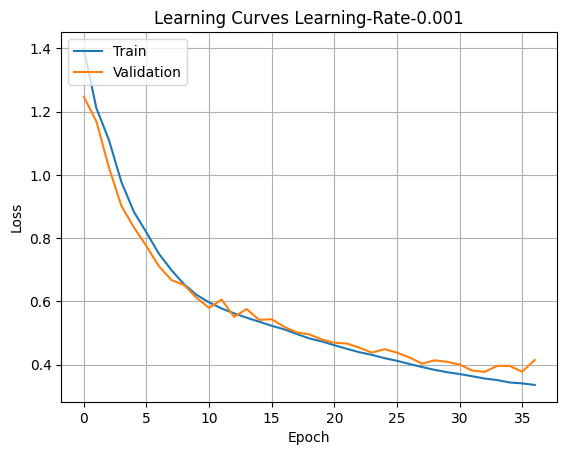

Model: "Learning-Rate-0.005"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_207 (Dense)           (None, 32)                1664      
                                                                 
 dense_208 (Dense)           (None, 16)                528       
                                                                 
 dense_209 (Dense)           (None, 16)                272       
                                                                 
 dense_210 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 4ms/step - loss: 1.1005 - accuracy: 0.5497 - val_loss: 0.9149 - val_accuracy: 0.6378
Epoch

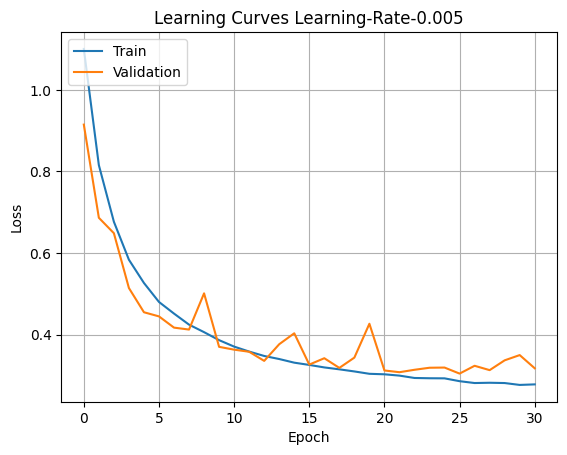

Model: "Learning-Rate-0.01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_211 (Dense)           (None, 32)                1664      
                                                                 
 dense_212 (Dense)           (None, 16)                528       
                                                                 
 dense_213 (Dense)           (None, 16)                272       
                                                                 
 dense_214 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 5s 5ms/step - loss: 1.1721 - accuracy: 0.5051 - val_loss: 0.9206 - val_accuracy: 0.6454
Epoch 

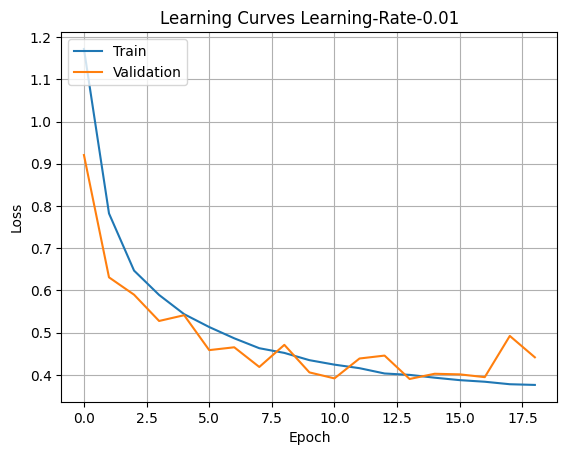

Model: "Learning-Rate-0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_215 (Dense)           (None, 32)                1664      
                                                                 
 dense_216 (Dense)           (None, 16)                528       
                                                                 
 dense_217 (Dense)           (None, 16)                272       
                                                                 
 dense_218 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 5ms/step - loss: 1.6171 - accuracy: 0.2061 - val_loss: 1.6092 - val_accuracy: 0.2140
Epoch 2

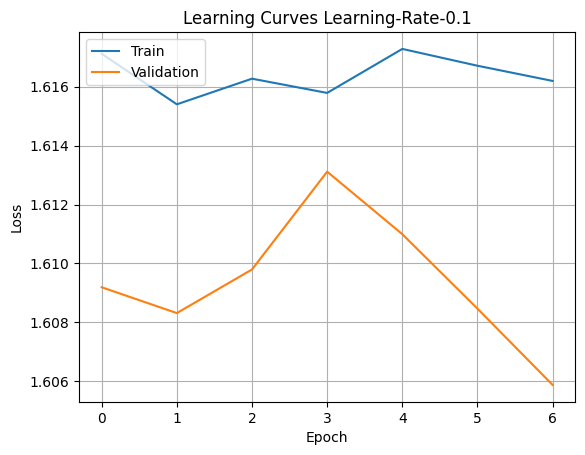

In [73]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 40
# Number of layers: 3
# Number of nodes per each layer: 32-16-16
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_uniform'
# Batch Normalization: not added
model_config['optimizer'] = 'rmsprop'

#learning_rate_list = [0.001, 0.005, 0.01, 0.1, 0.5]
learning_rate_list = [0.001, 0.005, 0.01, 0.1]

for learning_rate in learning_rate_list:

  model_config['learning_rate'] = learning_rate

  custom_layers = [
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(16,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(16,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Learning-Rate-' + str(learning_rate)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [74]:
accuracy_measures_learning_rate = accuracy_measures.copy()

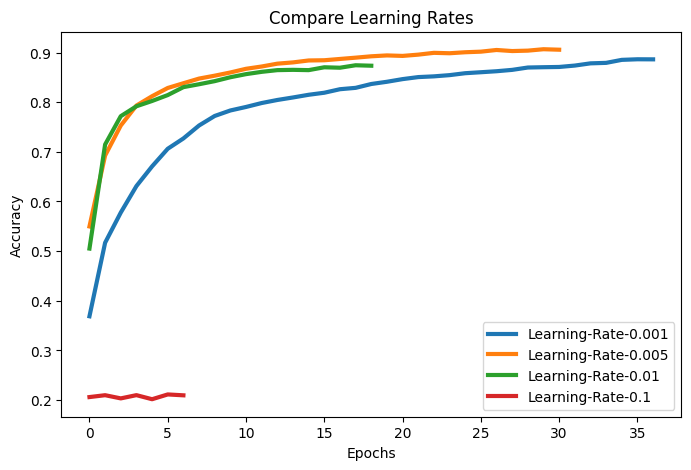

In [75]:
plot_accuracy_measures(accuracy_measures, "Compare Learning Rates")

The learning rate 0.005 offers a higher accuracy but it is unstable compared to 0.001. Thus, selecting the model with a learning rate of 0.001

In [76]:
model_config['learning_rate'] = 0.001

## Overfitting Management

### Regularization
Regularization is an important technique for managing overfitting in neural networks. Regularization algorithms provide an adjustments to the model parameters after they are updated. The adjustment reduces the variance in the model by providing a penalty when overfitting.

Testing: l1
Model: "Regularizer-l1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_235 (Dense)           (None, 32)                1664      
                                                                 
 dense_236 (Dense)           (None, 16)                528       
                                                                 
 dense_237 (Dense)           (None, 16)                272       
                                                                 
 dense_238 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.6292 - accuracy: 0.2084 - val_loss: 1.6163 - val_accuracy: 0.214

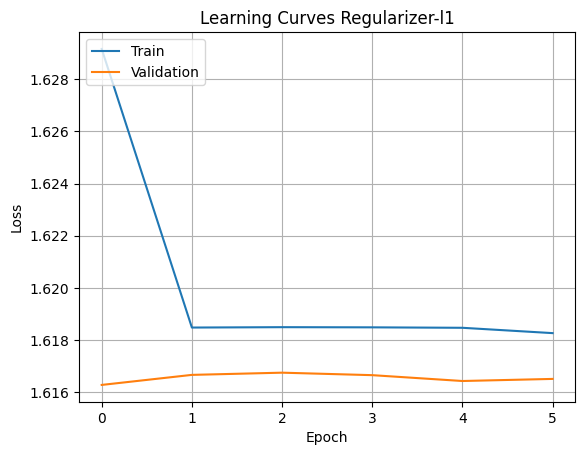

Testing: l2
Model: "Regularizer-l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_239 (Dense)           (None, 32)                1664      
                                                                 
 dense_240 (Dense)           (None, 16)                528       
                                                                 
 dense_241 (Dense)           (None, 16)                272       
                                                                 
 dense_242 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 5ms/step - loss: 1.6082 - accuracy: 0.2135 - val_loss: 1.6059 - val_accuracy: 0.214

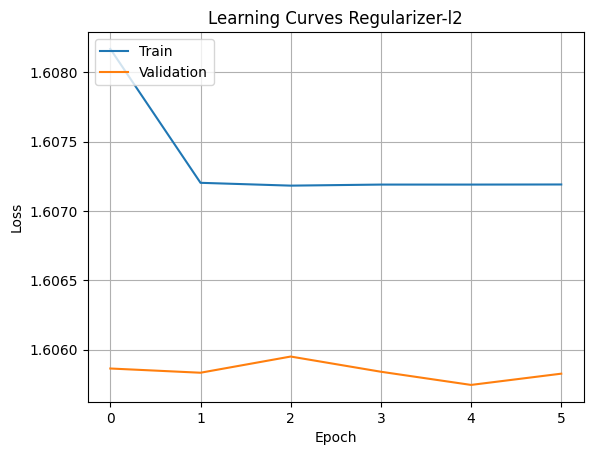

Testing: l1_l2
Model: "Regularizer-l1_l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_243 (Dense)           (None, 32)                1664      
                                                                 
 dense_244 (Dense)           (None, 16)                528       
                                                                 
 dense_245 (Dense)           (None, 16)                272       
                                                                 
 dense_246 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 5s 6ms/step - loss: 1.6301 - accuracy: 0.2127 - val_loss: 1.6175 - val_accuracy:

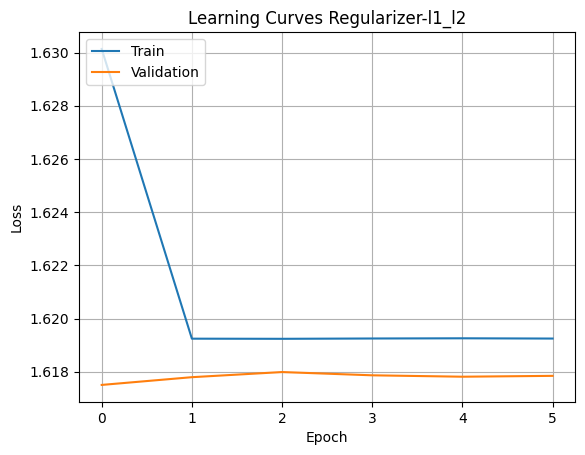

Testing: None
Model: "Regularizer-None"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_247 (Dense)           (None, 32)                1664      
                                                                 
 dense_248 (Dense)           (None, 16)                528       
                                                                 
 dense_249 (Dense)           (None, 16)                272       
                                                                 
 dense_250 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 4ms/step - loss: 1.5089 - accuracy: 0.3013 - val_loss: 1.4046 - val_accuracy: 0

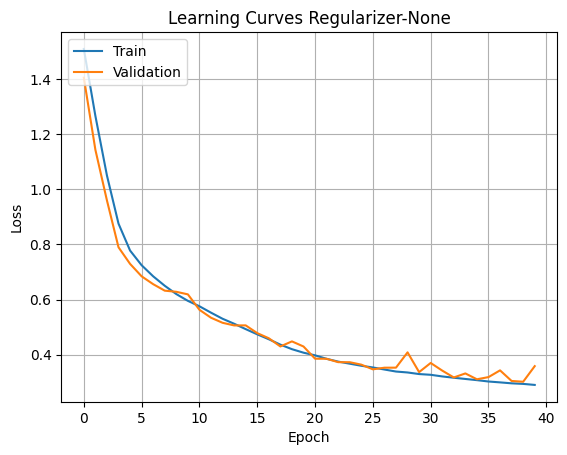

In [79]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 40
# Number of layers: 3
# Number of nodes per each layer: 32-16-16
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_uniform'
# Batch Normalization: not added
model_config['optimizer'] = 'rmsprop'
model_config['learning_rate'] = 0.001

regularizer_list = ['l1','l2','l1_l2', 'None']

for regularizer in regularizer_list:
  if regularizer == 'None':
    regularizer = None

  model_config['regularizer'] = regularizer
  print('Testing: {}'.format(regularizer))

  custom_layers = [
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Regularizer-' + str(regularizer)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)

  # Used the validation accuracy
  accuracy_measures[model_name] = history.history['val_accuracy']

In [ ]:
accuracy_measures_regularizer = accuracy_measures.copy()

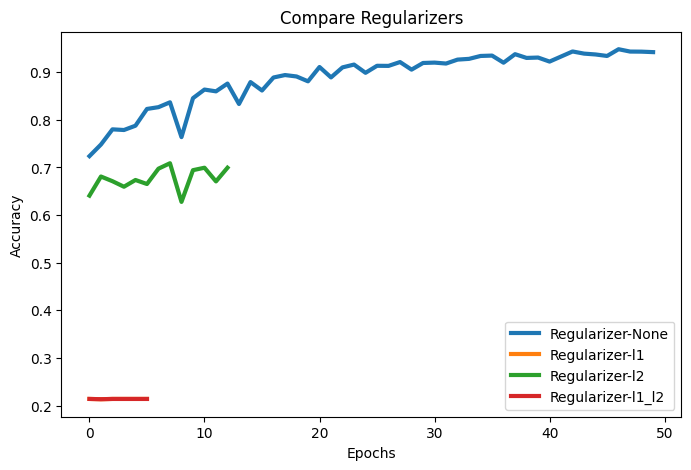

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Regularizers")

The l2 regularizer produce better accuracy and stability.

In [ ]:
model_config['regularizer'] = None

### Dropout
Dropout works during forward propagation. By default, during forward propagation, the  output of each node in the layer is sent every node in the next layer. When using dropout, the outputs of some of the nodes in the layer are dropped randomly.

Model: "Dropout-None"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_271 (Dense)           (None, 32)                1664      
                                                                 
 dense_272 (Dense)           (None, 16)                528       
                                                                 
 dense_273 (Dense)           (None, 16)                272       
                                                                 
 dense_274 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.4649 - accuracy: 0.3517 - val_loss: 1.3361 - val_accuracy: 0.4165
Epoch 2/40
6

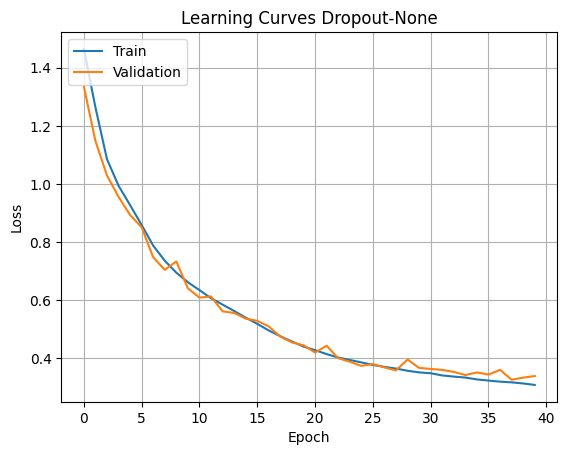

Model: "Dropout0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_275 (Dense)           (None, 32)                1664      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_276 (Dense)           (None, 16)                528       
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_277 (Dense)           (None, 16)                272       
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_278 (Dense)           (None, 5)                

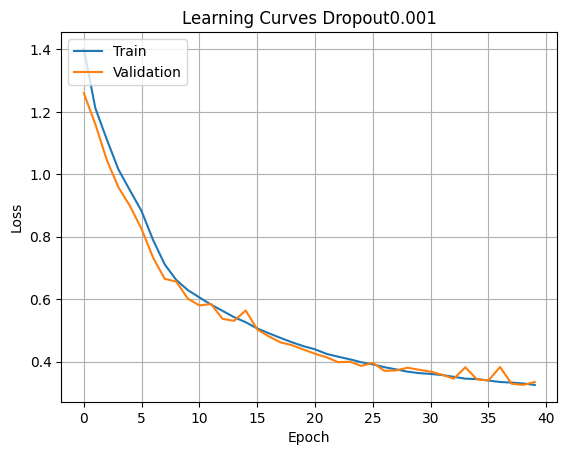

Model: "Dropout0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_279 (Dense)           (None, 32)                1664      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_280 (Dense)           (None, 16)                528       
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_281 (Dense)           (None, 16)                272       
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_282 (Dense)           (None, 5)                 8

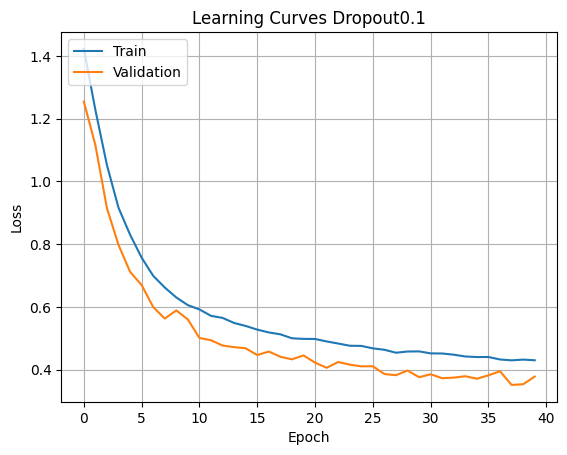

Model: "Dropout0.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_283 (Dense)           (None, 32)                1664      
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_284 (Dense)           (None, 16)                528       
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_285 (Dense)           (None, 16)                272       
                                                                 
 dropout_20 (Dropout)        (None, 16)                0         
                                                                 
 dense_286 (Dense)           (None, 5)                 8

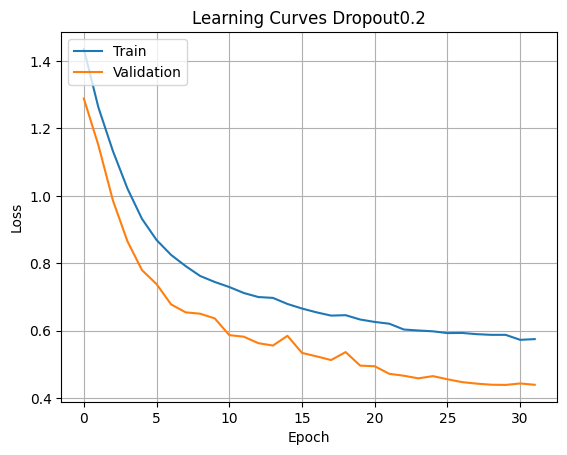

Model: "Dropout0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_287 (Dense)           (None, 32)                1664      
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_288 (Dense)           (None, 16)                528       
                                                                 
 dropout_22 (Dropout)        (None, 16)                0         
                                                                 
 dense_289 (Dense)           (None, 16)                272       
                                                                 
 dropout_23 (Dropout)        (None, 16)                0         
                                                                 
 dense_290 (Dense)           (None, 5)                 8

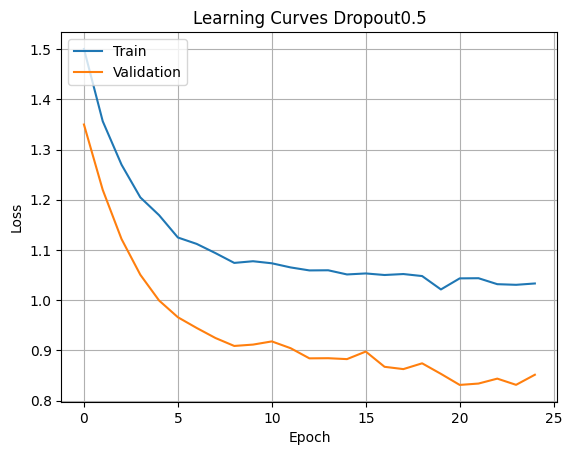

In [83]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 40
# Number of layers: 3
# Number of nodes per each layer: 32-16-16
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_uniform'
# Batch Normalization: not added
model_config['optimizer'] = 'rmsprop'
model_config['learning_rate'] = 0.001
model_config['regularizer'] = None
model_config['dropout_rate'] = None

dropout_list = [0.0, 0.001, 0.1, 0.2, 0.5]

for dropout in dropout_list:

  model_config['dropout_rate'] = dropout

  custom_layers = []

  if model_config['dropout_rate'] > 0.0:
    model_name = 'Dropout' + str(dropout)
    custom_layers = [
      layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ]
  else:
    model_name = 'Dropout-None'
    custom_layers = [
      layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ]

  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)

  # Used the validation accuracy
  accuracy_measures[model_name] = history.history['val_accuracy']

In [84]:
accuracy_measures_dropout = accuracy_measures.copy()

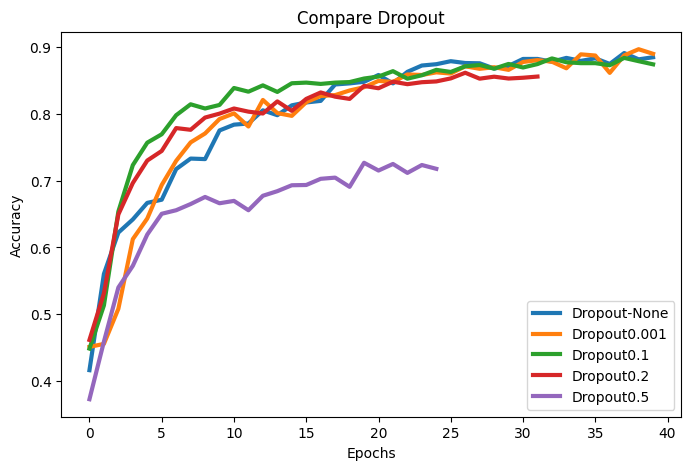

In [85]:
plot_accuracy_measures(accuracy_measures, "Compare Dropout")

The result of dropout experiment shows a close result between Dropout-None and Dropout0.001. I will choose the model Dropout0.001 because of small reduction in overfitting but slightly higher accuracy.

In [ ]:
model_config['dropout_rate'] = 0.001

# Model - Evaluation

In [98]:
def get_best_param_model_config(model_name):
  """
  (str) -> dict

  This method returns the best hyper parameters from experiments.

  Parameters
  ----------
  model_name - The name of the model

  Returns
  ----------
  dict - The dictionary containing the best hyper parameters from experiments.
  """
  # Default model config
  model_config = get_base_model_config()

  model_config['model_name'] = model_name

  # These are the final hyperparameters that I will use in training the Models:
  # Hyperparameters:
  model_config['batch_size'] = 32
  model_config['epochs'] = 40
  # Number of layers: 3
  # Number of nodes per each layer: 32-16-16
  model_config['hidden_activation'] = 'relu'
  model_config['weights_initializer'] = 'random_uniform'
  # Batch Normalization: not added
  model_config['optimizer'] = 'rmsprop'
  model_config['learning_rate'] = 0.001
  model_config['regularizer'] = None
  model_config['dropout_rate'] = 0.001

  custom_layers = [
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dropout(model_config['dropout_rate']),
    layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dropout(model_config['dropout_rate']),
    layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dropout(model_config['dropout_rate']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  # we would like to save the model starting here for evaluation.
  model_config['is_save_model'] = True

  return model_config

In [105]:
from keras.models import load_model

def evaluate_model(model_config, X, y):
  """
  (dict, tf.data.Dataset)

  This is a reusable function that load a previously trained model and run an evaluation.

  Parameters
  ----------
  model_config - The dictionary to use in model evaluation.
  test_ds - The test dataset to use in the evaluation.

  Returns
  ----------
  Dataframe - The Panda Dataframe containing the scores from the experiment. The scores includes the Accuracy and Loss.
  """
  model_file = str(model_config['workspace_path']) + str(model_config['model_name']) + '.h5'
  model = load_model(model_file)


  test_loss, test_acc = model.evaluate(X, y, verbose=model_config['verbose'])
  print(f"Test accuracy: {test_acc}")

In [106]:
# reset accuracy measures
accuracy_measures = {}

In [109]:
model_name = 'Multiclass_Clarissification_of_Malicious_URL'
model_config = get_best_param_model_config(model_name)

model_1_history = create_and_run_model(model_config, X_train, y_train_dummy)

Model: "Multiclass_Clarissification_of_Malicious_URL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_307 (Dense)           (None, 32)                1664      
                                                                 
 dropout_33 (Dropout)        (None, 32)                0         
                                                                 
 dense_308 (Dense)           (None, 16)                528       
                                                                 
 dropout_34 (Dropout)        (None, 16)                0         
                                                                 
 dense_309 (Dense)           (None, 16)                272       
                                                                 
 dropout_35 (Dropout)        (None, 16)                0         
                                                                 
 dense_310 (Dense)    

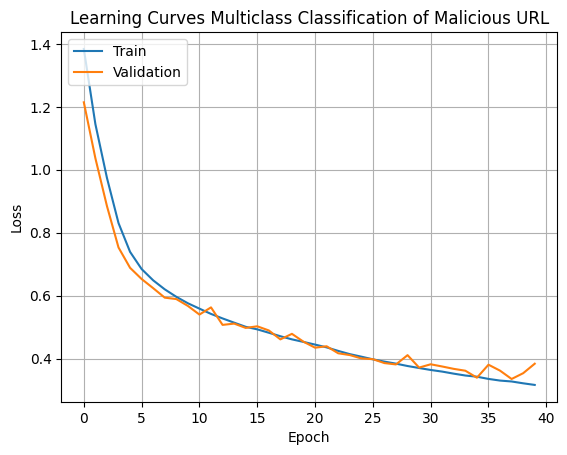

In [108]:
plot_learning_curves(model_1_history, model_name)

In [104]:
evaluate_model(model_config, X_test, y_test_dummy)

341/341 - 1s - loss: 0.3873 - accuracy: 0.8622 - 870ms/epoch - 3ms/step
Test accuracy: 0.8622271418571472


In [111]:
tuned_model = Sequential(layers=model_config['custom_layers'], name=model_config['model_name'])
tuned_model.summary()

optimizer = get_optimizer(model_config["optimizer"], model_config["learning_rate"])

# Compile the model
tuned_model.compile(optimizer=optimizer,
              loss=model_config['loss'],
              metrics=model_config['metrics'])

estimator = KerasClassifier(model=tuned_model, epochs=model_config['epochs'], batch_size=model_config['batch_size'], verbose=model_config['verbose'])
kfold = KFold(n_splits=2, shuffle=True)
results = cross_val_score(estimator, X_train, y_train_dummy, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Model: "Multiclass_Clarissification_of_Malicious_URL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_307 (Dense)           (None, 32)                1664      
                                                                 
 dropout_33 (Dropout)        (None, 32)                0         
                                                                 
 dense_308 (Dense)           (None, 16)                528       
                                                                 
 dropout_34 (Dropout)        (None, 16)                0         
                                                                 
 dense_309 (Dense)           (None, 16)                272       
                                                                 
 dropout_35 (Dropout)        (None, 16)                0         
                                                                 
 dense_310 (Dense)    